# Post Hoc Relabeling

### Basic idea
This is use case example of the *Post-Hoc relabeling* method developed by Castaño-Candamil et al., 2019, in [Post-hoc Labeling of Arbitrary M/EEG Recordings for Data-Efficient Evaluation of Neural Decoding Methods](https://www.frontiersin.org/articles/10.3389/fninf.2019.00055/full). The basic idea as detailed in the paper, builds on the assumption cognitive and motor activity can be decoded from narrow band power of just a few bipol sources. The method uses existing arbitray EEG/MEG recordings and derives source space activity from them. This can be done following either:

1. An anatomically constrained mode, where a forward model, e.g. derived from an average head, is used to estimate the sources activity;
1. data driven approach, which uses any blind source separation method, such as e.g. ICA, to derive synthetic sources.
   With these source projections, the user can manipulate source data to synthetically create certain features like signal power or SNR.

### This notebook
This notebook will demonstrate the use of the *Post-Hoc Relabeling* method to generate augmented EEG for evaluating the impact of regularization following the extended CSP approach (rCSP) proposed by [Lotte et al., 2010](https://ieeexplore.ieee.org/document/5593210). We will make use of the data driven approach by extracting ICA sources from a single subjects session of the [`Schirrmeister2017`](http://moabb.neurotechx.com/docs/generated/moabb.datasets.Schirrmeister2017.html) [MOABB](http://moabb.neurotechx.com/docs/index.html) data set.

In [4]:
# Diagramm of the process
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
flowchart LR
    subgraph Post-Hoc Relabeling
        I(ICA) --> L[encode sources]
    end
    subgraph Schirrmeister2017
        E[EEG Data] --> I
    end
    subgraph Grid search
        L --> P[Parameter sweep]
        P --> R(rCSP)
        E --> R
    end
""")

In [5]:
# The dependencies to load - should be mostly standard
import mne

import numpy as np
import pandas as pd

from itertools import product
from moabb.datasets import Schirrmeister2017

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score

from multiprocess import Pool

In [6]:
# The data extraction - we chose an arbitray MOABB set and take only one subject/session
# for demonstration purposes

def load_data(subject: int = 3) -> dict[str, mne.io.BaseRaw]:
    """Lets prefer working with mne"""
    dataset = Schirrmeister2017()
    dataset.subject_list = [subject]
    rawd = dataset.get_data()

    # band filter and resample for faster processing
    l_freq = 1
    h_freq = 40
    raw = rawd[3]["session_0"]["train"]
    raw.load_data().filter(l_freq, h_freq).resample(100)

    return rawd[subject]["session_0"]['train']

def raw_to_epochs(raw: mne.io.BaseRaw) -> mne.Epochs:
    """Convert raw to epochs"""
    events, evid = mne.events_from_annotations(raw)
    epochs = mne.Epochs(
        raw,
        events,
        tmin=-0.25,
        tmax=4,
        baseline=None,
        reject={"eeg": 80e-6},
        preload=True,
    )
    return epochs

raw = load_data()
epochs = raw_to_epochs(raw)

# select only 32 channels, again for brevity of this demonstration
epochs = epochs.pick_types(eeg=True).pick(range(32))

Extracting EDF parameters from /Users/matthias.dold/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/train/3.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as type EEG (renamed to 'Fz').
Channel 'EEG F4' recognized as type EEG (renamed to 'F4').
Channel 'EEG F8' recognized as type EEG (renamed to 'F8').
Channel 'EEG FC5' recognized as type EEG (renamed to 'FC5').
Channel 'EEG FC1' recognized as type EEG (renamed to 'FC1').
Channel 'EEG FC2' recognized as type EEG (renamed to 'FC2').
Channel 'EEG FC6' recognized as type EEG (renamed to 'FC6').
Channel 'EEG M1' recognized as type EEG (renamed to 'M1').
Channel 'EEG T7' recognized as type EEG (renamed to 

Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/matthias.dold/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/test/3.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as type EEG (renamed to 'Fz').
Channel 'EEG F4' recognized as type EEG (renamed to 'F4').
Channel 'EEG F8' recognized as type EEG (renamed to 'F8').
Channel 'EEG FC5' recognized as type EEG (renamed to 'FC5').
Channel 'EEG FC1' recognized as type 

Channel 'EEG PPO10h' recognized as type EEG (renamed to 'PPO10h').
Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3347499  =      0.000 ...  6694.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    5.5s finished


Used Annotations descriptions: ['feet', 'left_hand', 'rest', 'right_hand']
Not setting metadata
880 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 880 events and 426 original time points ...
    Rejecting  epoch based on EEG : ['M2', 'PO9', 'P9']
    Rejecting  epoch based on EEG : ['PO9', 'P9']
    Rejecting  epoch based on EEG : ['M2', 'TPP9h']
    Rejecting  epoch based on EEG : ['PO9', 'P9']
    Rejecting  epoch based on EEG : ['PO9', 'P9']
    Rejecting  epoch based on EEG : ['M1', 'TPP9h']
    Rejecting  epoch based on EEG : ['M1', 'TPP9h', 'PO9', 'P9', 'I1', 'PPO9h']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['M2']
    Rejecting  epoch based on EEG : ['P7', 'PO9', 'P9', 'P10']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'Fpz', 'AF7', 'AF3', 'AFz', 'AFp3h', 'AFp4h', 'AFF5h']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['PO9', 'P9']
  

    Rejecting  epoch based on EEG : ['TPP9h', 'P9']
    Rejecting  epoch based on EEG : ['M1', 'M2', 'P7', 'TPP9h', 'PO9', 'P9', 'P10', 'I1', 'PPO9h', 'POO9h']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'Fpz', 'F7', 'M1', 'M2', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'TPP10h', 'P10', 'AFF1', 'AFz', 'Iz', 'I2', 'AFp3h', 'AFp4h', 'AFF5h']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['M2', 'P9']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['PO9', 'P9']
    Rejecting  epoch based on EEG : ['PO9', 'P9']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['M1']
    Rejecting  epoch based on EEG : ['M1', 'TPP9h', 'PO9', 'P9', 'I1', 'POO9h']
    Rejecting  epoch based on EEG : ['M1', 'M2', 'TPP9h', 'PO9', 'P9']
    Rejecting  epoch based on EEG : ['TPP9h', 'P9']
    Rejecting  epoch based on EEG : ['PO9', 'P9']
    Rejecting  epoch based on EEG : ['M2', 'P9']
    Rejecting  epoch based on EEG : 

    Rejecting  epoch based on EEG : ['TPP9h']
    Rejecting  epoch based on EEG : ['M1', 'P9']
    Rejecting  epoch based on EEG : ['M1', 'TPP9h', 'P9', 'I1', 'PPO9h']
    Rejecting  epoch based on EEG : ['TPP9h', 'PO9', 'P9']
    Rejecting  epoch based on EEG : ['M1', 'M2', 'O1', 'PO7', 'TPP9h', 'PO9', 'P9', 'I1', 'Iz', 'PPO9h', 'POO9h', 'OI1h']
    Rejecting  epoch based on EEG : ['M1', 'M2', 'TPP9h', 'P9', 'I1']
    Rejecting  epoch based on EEG : ['M1', 'M2', 'P7', 'TP7', 'PO7', 'FT10', 'TPP9h', 'PO9', 'P9', 'P10', 'PPO9h']
    Rejecting  epoch based on EEG : ['M1', 'TPP9h']
    Rejecting  epoch based on EEG : ['M2', 'TPP9h', 'TPP10h', 'P9', 'P10']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['T7', 'FT9', 'FTT9h']
    Rejecting  epoch based on EEG : ['PO9', 'P9']
    Rejecting  epoch based on EEG : ['TPP9h', 'P9']
    Rejecting  epoch based on EEG : ['M1', 'T7', 'M2', 'FT9', 'P9']
    Rejecting  epoch based on EEG : ['M1', 'T7', 'M2', 'TP7', 'TPP9

    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['T7', 'P7', 'TP7', 'TPP9h', 'P9', 'PPO9h']
    Rejecting  epoch based on EEG : ['M1', 'T7', 'TPP9h', 'P9']
    Rejecting  epoch based on EEG : ['M1', 'M2', 'TP7', 'TPP9h', 'TPP10h', 'PO9', 'P9', 'P10', 'I1', 'Iz', 'I2', 'PPO9h']
    Rejecting  epoch based on EEG : ['I1']
    Rejecting  epoch based on EEG : ['M1', 'T7', 'M2', 'TP7', 'FT9', 'TPP9h', 'P9']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'Fpz', 'F8', 'M1', 'T7', 'T8', 'M2', 'P7', 'O1', 'AF7', 'AF8', 'P5', 'PO5', 'FT8', 'TP7', 'TP8', 'PO7', 'FT9', 'FT10', 'TPP9h', 'TPP10h', 'PO9', 'PO10', 'P9', 'P10', 'I1', 'Iz', 'I2', 'AFp4h', 'FTT9h', 'FTT10h', 'TPP7h', 'PPO9h', 'POO9h', 'OI1h']
    Rejecting  epoch based on EEG : ['T7', 'TP7']
    Rejecting  epoch based on EEG : ['M1', 'T7', 'TP7', 'TPP9h', 'P9']
    Rejecting  epoch based on EEG : ['M1', 'T7', 'M2', 'TP7', 'FT9', 'FT10', 'FTT10h']
    Rejecting  epoch based on EEG : ['M1', 'T7', 'P7', 'P

    Rejecting  epoch based on EEG : ['T7', 'TP7', 'P9', 'I1']
    Rejecting  epoch based on EEG : ['M1', 'M2', 'P7', 'TP7', 'PO7', 'FT9', 'FT10', 'TPP9h', 'TPP10h', 'PO9', 'PO10', 'P9', 'P10', 'I1', 'Iz', 'I2', 'FTT9h', 'FTT10h', 'TPP7h', 'PPO9h', 'POO9h', 'POO10h', 'OI1h', 'OI2h']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['M1', 'T7', 'TP7', 'FT9', 'FTT9h']
    Rejecting  epoch based on EEG : ['T7', 'TP7']
    Rejecting  epoch based on EEG : ['TP7', 'TPP9h', 'P9']
    Rejecting  epoch based on EEG : ['M1', 'T7', 'TP7', 'TPP9h', 'P10', 'FTT9h']
    Rejecting  epoch based on EEG : ['T7', 'TP7', 'TPP9h', 'I1']
    Rejecting  epoch based on EEG : ['M1', 'T7', 'M2', 'P7', 'TP7', 'PO7', 'TPP9h', 'PO9', 'P9', 'I1', 'PPO9h', 'POO9h']
    Rejecting  epoch based on EEG : ['T7', 'TP7']
    Rejecting  epoch based on EEG : ['T7', 'TP7', 'TPP9h', 'P9']
    Rejecting  epoch based on EEG : ['M1', 'T7', 'M2', 'FT7', 'TP7'

## Post-hoc relabeling for label extraction
We get a complete label vector for each source we find using ICA.

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 165 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 12288 out of 12288 | elapsed:    0.5s finished


Fitting ICA took 14.2s.


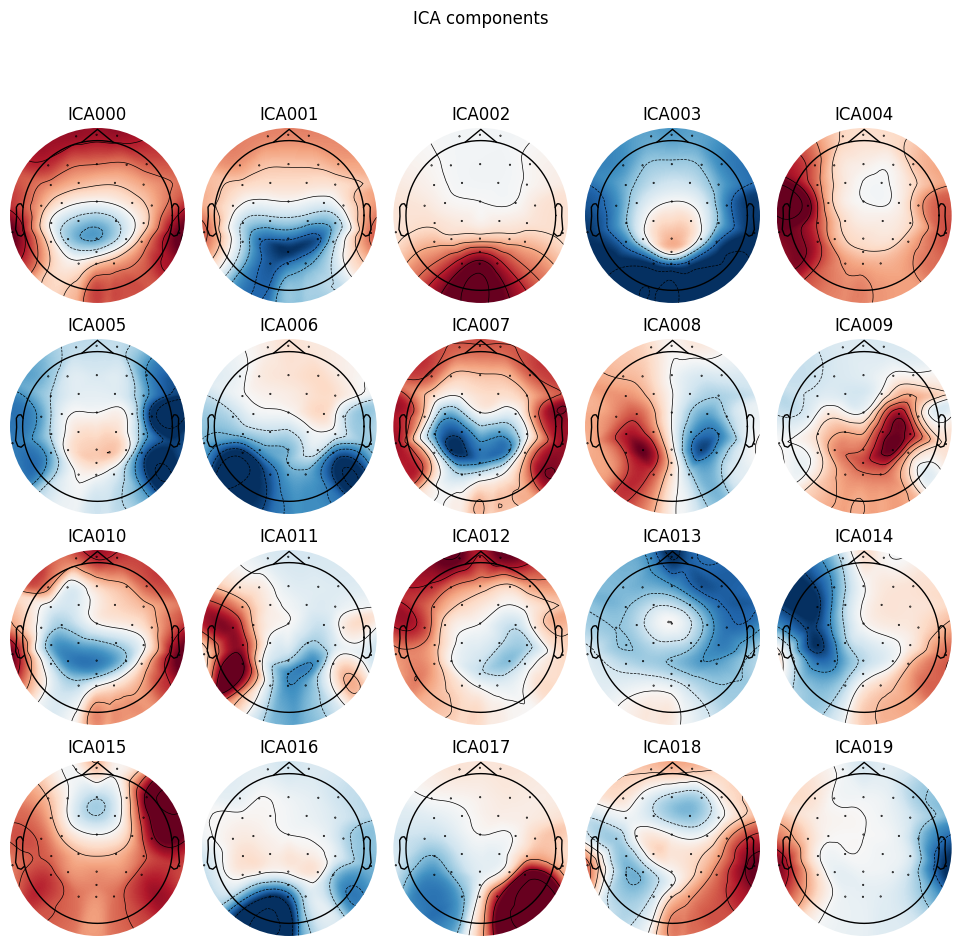

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
384 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
384 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
384 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
384 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
384 matching events found
No baseline correction applied
0 projection items activated


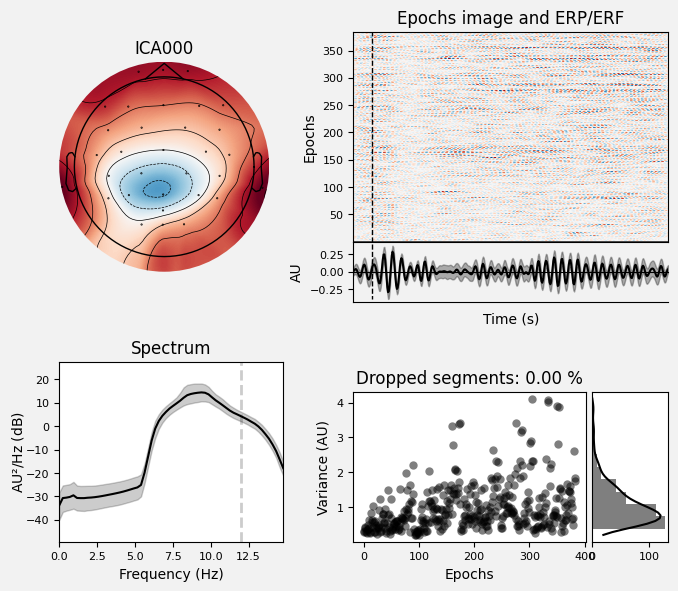

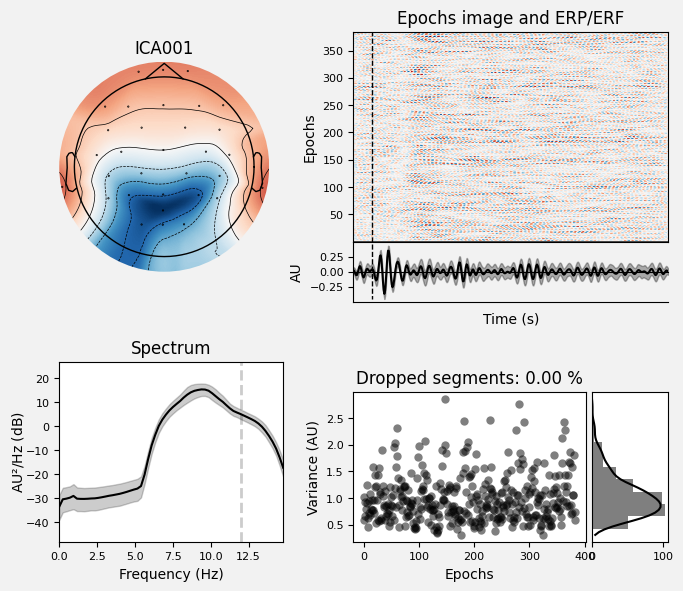

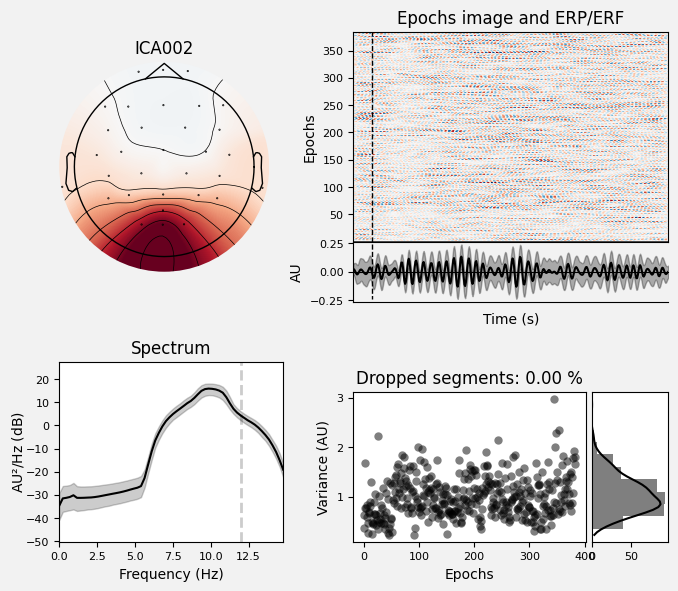

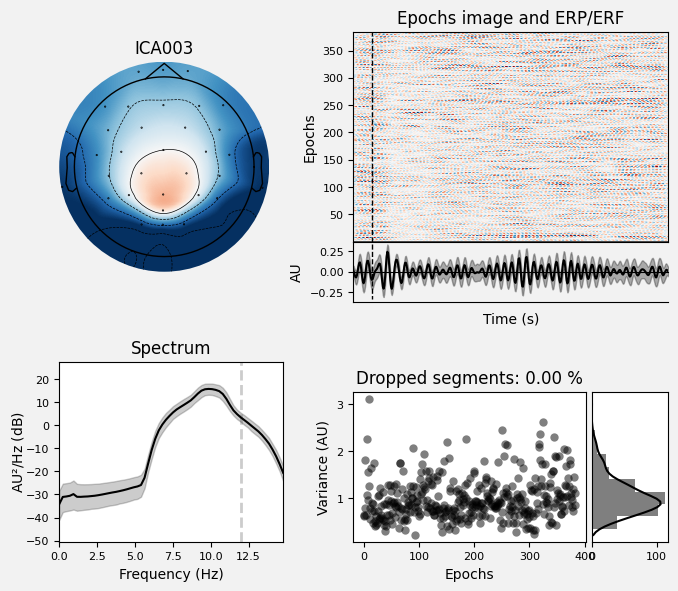

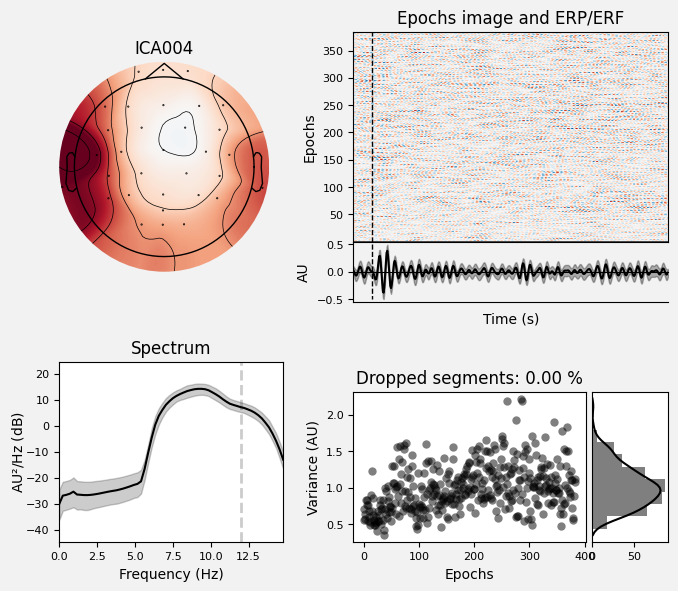

In [7]:
# Step 1 - source activity for ICA components
epo_narrow = epochs.copy().filter(8, 12)
ica_narrow = mne.preprocessing.ICA(n_components=20, random_state=42)
ica_narrow.fit(epo_narrow)

# visual inspection and potential exclusion --> all look reasonably like neural activity
# ica_narrow.plot_components()
# ica_narrow.plot_properties(epo_narrow)
ica_narrow.exclude = []

# get the narrow band sources
ica_sources = ica_narrow.get_sources(epo_narrow)

In [9]:
# Step 2 - encode classification labels, here for two classes simply using the median as threshold
def extract_classification_labels(epos: mne.BaseEpochs) -> np.ndarray:
    """Extract labels for classification from each of the epochs channels"""

    labels = []
    power = np.std(epos.get_data(), axis=2)
    for ic, cn in enumerate(epos.ch_names):
        v = power[:, ic]
        labels.append((v > np.median(v)).astype(int))

    return labels

labels_list = extract_classification_labels(ica_sources)


## Using the relabeled data
We now use our augmented data set to investigate how the rCSP approaches regularization can deal with different levels of label noise.

#### Defining the rCSP

In [13]:
class rCSP(mne.decoding.CSP):
    """
    A renormalized version of CSP following Lotte et al., 2010 - https://ieeexplore.ieee.org/document/5593210
    """
    def __init__(
        self,
        n_components: int = 4,
        gamma: float = 0,
        alpha: float = 0,
        **kwargs,
    ):
        """

        Parameters
        ----------
        gamma : float
            regularization parameter for initial spatial covariance matrix estimation

        alpha : float
            regularization parameter for M matrix estimation, used to weight the prior
        """
        # Ensure an even number of components as the regularization approach
        # will consider a separate eigenvalue decomposition for each class,
        # and we assume only binary class cases here.
        assert (
            n_components % 2 == 0
        ), "n_components must be even for this example"

        # new parameters
        self.gamma = gamma
        self.alpha = alpha
        super().__init__(
            n_components=n_components,
            reg=gamma,  # if reg is a float, mne will automatically setup a shrinkage covariance
            transform_into="average_power",
            **kwargs,
        )
        self.filters_ = None
        self.patters_ = None

    def compute_rCSP_components(
        self, X: np.ndarray, y: np.ndarray
    ) -> tuple[tuple[np.ndarray, np.ndarray]]:
        """

        Parameters
        ----------
        X : np.ndarray
            data in shape of (n_trials, n_channels, n_times)

        y : np.ndarray
            class labels of shape (n_trials,)

        gamma : float
            regularization parameter for initial spatial covariance matrix estimation

        alpha : float
            regularization parameter for M matrix estimation, used to weight the prior

        Returns
        -------
        ((lambda1, u1), (lambda2, u2))
            such that lambda<i> is the list of eigenvalues, sorted in decreasing order,
            of matrix M<i>, and u<i> is the matrix containing the eigenvectors sorted the same way.

        For more details on the variable names,
        refer to Lotte et al., 2010 - https://ieeexplore.ieee.org/document/5593210

        """
        classes = np.unique(y)
        assert len(classes) == 2, "Expecting a binary classification task"
        C, _ = self._compute_covariance_matrices(X, y)
        self.cs = C

        # compute the M matrices:
        n_features = C[0].shape[0]
        M = [
            np.dot(np.linalg.inv(C[1] + self.alpha * np.eye(n_features)), C[0]),
            np.dot(np.linalg.inv(C[0] + self.alpha * np.eye(n_features)), C[1]),
        ]
        self.ms = M
        output = []
        for Mc in M:
            # compute the eigenvalues and eigenvectors:
            evals, evecs = np.linalg.eig(Mc)
            evals = evals.real
            evecs = evecs.real

            # sort the eigenvectors according to the eigenvalues:
            idx = np.argsort(np.abs(evals))[::-1]
            output.append((evals[idx], evecs[:, idx].T))

        return output

    def fit(self, X: mne.BaseEpochs, y: np.ndarray):
        self._check_Xy(X, y)
        self._classes = np.unique(y)

        # Compute the filters - the rows of u1 and u2
        (lambda1, u1), (lambda2, u2) = self.compute_rCSP_components(X, y)

        lbd = np.hstack([lambda1, lambda2])
        self.lbd = lbd

        # stack together like in alternating sort or original csp
        u = np.asarray([e for a, b in zip(u1, u2) for e in [a, b]])

        # Save the filters and patterns:
        self.filters_ = u
        self.patterns_ = np.linalg.pinv(u.T)

        pick_filters = self.filters_[: self.n_components]
        X = np.asarray([np.dot(pick_filters, epoch) for epoch in X])

        # compute features (mean power)
        X = (X**2).mean(axis=2)

        # To standardize features
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)

        return self

In [21]:
# Convenience function for multiprocessing
def calc_cv_scores(
    params: dict,
) -> dict:
    # Using the simplest approach for multiprocessing with pools can only handle one arg per function
    # so we simply process a dict here
    X = params["X"]
    y = params["y"]
    alpha = params["alpha"]
    epsilon = params["epsilon"]
    gamma = params["gamma"]
    splits = params["splits"]
    
    print(f"Processing: {alpha=}, {epsilon=}, {gamma=}")
    clf = Pipeline(
        [
            (
                "spatial_filter",
                rCSP(
                    n_components=4,
                    gamma=gamma,
                    alpha=alpha,
                    log=True,
                ),
            ),
            ("classifier", LDA(solver="eigen", shrinkage="auto")),
        ]
    )
    roc_scores = []
    ytrain = introduce_label_error(y, epsilon=epsilon)
    for ixtrain, ixtest in splits:
        clf.fit(X[ixtrain], ytrain[ixtrain])
        y_pred = clf.predict(X[ixtest])
        roc_scores.append(roc_auc_score(y[ixtest], y_pred))

    return {
        "gamma": gamma,
        "alpha": alpha,
        "epsilon": epsilon,
        "roc_scores": roc_scores,
        "splits": splits,
        "patterns": clf["spatial_filter"].patterns_,
        "filters": clf["spatial_filter"].filters_,
    }

In [15]:
# Flip labels to introduce label error. This follows the convention used in the original paper
# by Castano et al., 2019, in which an epsilon=0 means no label noise and epsilon=1 means
# labels will always be wrong.
def introduce_label_error(labels: np.ndarray, epsilon: float = 0) -> np.ndarray:
    nlabels = labels.copy().astype(bool)

    # depending on eps, we introduce a label error for that fraction of labels
    size = int(epsilon * len(nlabels))
    idx = np.random.choice(range(len(nlabels)), size=size, replace=False)
    nlabels[idx] = ~nlabels[idx]

    return nlabels.astype(int)

### Parameter sweep evaluation
Here we sweep accross a grid of parameter and evaluate the rCSP with the given parameter set.
We will change the two regularization paramters `gamma` and `alpha` while also looking at different levels of label noise.

In [20]:
# Perform the parameter sweep
X = epochs.get_data()
y = labels_list[0]   # just take the first label set to create the split, we will later use the
                     # same split for all sets and parameter values

# just use a single split here to speed up evaluation for the showcase
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
splits = list(cv.split(X, y))[:1]

paramgrid = {
    "gamma": [0, 0.1, 0.5],
    "alpha": [0, 0.1, 0.5],
    "epsilon": [0, 0.01, 0.1, 0.3, 0.5, 0.8],
}

mne.set_log_level("WARNING")

results = []

# Only use the first 5 labels, again for speed of the showcase
for i, y in enumerate(labels_list[:5]):
    with Pool(5) as pool:
        res = pool.map(
            calc_cv_scores,
            [
                dict(
                    X=X,
                    y=y,
                    alpha=alpha,
                    epsilon=epsilon,
                    gamma=gamma,
                    splits=splits,
                )
                for alpha, epsilon, gamma in product(
                    paramgrid["alpha"],
                    paramgrid["epsilon"],
                    paramgrid["gamma"],
                )
            ],
        )
        for r in res:
            r.update({"label_set": i})

    results += res

Processing: alpha=0, epsilon=0, gamma=0
Processing: alpha=0, epsilon=0.01, gamma=0
Processing: alpha=0, epsilon=0.1, gamma=0
Processing: alpha=0, epsilon=0.3, gamma=0
Processing: alpha=0, epsilon=0.5, gamma=0
[0.8697916666666665]
Processing: alpha=0, epsilon=0, gamma=0.1
[0.8489583333333333]
Processing: alpha=0, epsilon=0.3, gamma=0.1
[0.8645833333333335]
Processing: alpha=0, epsilon=0.01, gamma=0.1
[0.8645833333333335]
Processing: alpha=0, epsilon=0.1, gamma=0.1
[0.5833333333333333]
Processing: alpha=0, epsilon=0.5, gamma=0.1
[0.8802083333333334]
Processing: alpha=0, epsilon=0.01, gamma=0.5
[0.8802083333333333]
Processing: alpha=0, epsilon=0, gamma=0.5
[0.7552083333333334]
Processing: alpha=0, epsilon=0.3, gamma=0.5
[0.8645833333333334]
Processing: alpha=0, epsilon=0.1, gamma=0.5
[0.5572916666666666]
Processing: alpha=0, epsilon=0.5, gamma=0.5
[0.796875][0.859375]

Processing: alpha=0, epsilon=0.8, gamma=0
Processing: alpha=0.1, epsilon=0, gamma=0
[0.8541666666666665]
Processing: alph

Processing: alpha=0, epsilon=0.8, gamma=0.1
[0.5271739130434783]
Processing: alpha=0.1, epsilon=0.1, gamma=0.1
[0.5302173913043479]
Processing: alpha=0.1, epsilon=0.3, gamma=0.1
[0.5339130434782609]
Processing: alpha=0.1, epsilon=0, gamma=0.5
[0.2341304347826087]
Processing: alpha=0, epsilon=0.8, gamma=0.5
[0.5230434782608695]
Processing: alpha=0.1, epsilon=0.01, gamma=0.5
[0.5115217391304347]
Processing: alpha=0.1, epsilon=0.3, gamma=0.5
[0.5276086956521738]
Processing: alpha=0.1, epsilon=0.1, gamma=0.5
[0.5339130434782609]
[0.26956521739130435]
Processing: alpha=0.1, epsilon=0.5, gamma=0
[0.5339130434782609]
Processing: alpha=0.1, epsilon=0.8, gamma=0
[0.5321739130434783]
Processing: alpha=0.5, epsilon=0, gamma=0
Processing: alpha=0.5, epsilon=0.01, gamma=0
[0.5460869565217391]
Processing: alpha=0.5, epsilon=0.1, gamma=0
[0.4702173913043479]
Processing: alpha=0.1, epsilon=0.8, gamma=0.1
[0.5339130434782609]
Processing: alpha=0.5, epsilon=0, gamma=0.1
[0.5230434782608695]
Processing: 

Processing: alpha=0.5, epsilon=0.01, gamma=0.1
[0.44842657342657344]
Processing: alpha=0.1, epsilon=0.5, gamma=0.5
[0.5795454545454546]
Processing: alpha=0.5, epsilon=0, gamma=0.5
[0.4348776223776224]
Processing: alpha=0.1, epsilon=0.8, gamma=0.5
[0.5751748251748252]
Processing: alpha=0.5, epsilon=0.1, gamma=0.5
[0.5725524475524475]
Processing: alpha=0.5, epsilon=0.01, gamma=0.5
[0.48732517482517484]
Processing: alpha=0.5, epsilon=0.3, gamma=0
[0.39073426573426573]
Processing: alpha=0.5, epsilon=0.5, gamma=0
[0.5795454545454546]
Processing: alpha=0.5, epsilon=0.8, gamma=0
[0.5629370629370629]
[0.5786713286713286]
[0.5541958041958042]
Processing: alpha=0.5, epsilon=0.3, gamma=0.1
[0.4112762237762238]
Processing: alpha=0.5, epsilon=0.8, gamma=0.1
[0.4947552447552448]
Processing: alpha=0.5, epsilon=0.5, gamma=0.1
[0.5917832167832168]
Processing: alpha=0.5, epsilon=0.3, gamma=0.5
[0.4396853146853147]
Processing: alpha=0.5, epsilon=0.8, gamma=0.5
[0.5319055944055945]
Processing: alpha=0.5, 

### Visualization of results

In [23]:

def results_to_data_frame(results: list[dict]) -> pd.DataFrame:
    df = pd.DataFrame(results)

    # the aggregation we would use in case more than one fold is considered
    df["mean_roc"] = df["roc_scores"].apply(np.mean)
    return df

df = results_to_data_frame(results)

In [28]:
# Choose your favorite visualization library. Here will be an example using plotly
import plotly.express as px


def plot_overall_performance(df: pd.DataFrame):
    fig = px.line(
        df,
        x="epsilon",
        y="mean_roc",
        color="label_set",
        facet_col="gamma",
        facet_row="alpha",
    )
    fig.update_layout(hovermode='x', height=800)
    
    fig.show()
    
plot_overall_performance(df)